The following code is a Jupyter notebook adaptation of WaveletAnalysis.py made for easy use in Jupyter notebooks by users.

In [99]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
import scipy.interpolate as sci
import numpy as np

# from mpl_toolkits.axes_grid1 import make_axes_locatable

from waveletFunctions import wave_signif, wavelet
# I have rewritten wave_signif and wavelet, used here

In [101]:
# READ THE DATA
sst = np.loadtxt('sst_nino3.dat')  # input SST time series

# Interpolate missing values (not in original py script) but needed for proper data handling
missing_indices = np.isnan(sst)
indices = np.arange(len(sst))
interpolator = sci.interp1d(indices[~missing_indices], sst[~missing_indices], kind='linear')
sst[missing_indices] = interpolator(indices[missing_indices])


sst = sst - np.mean(sst)
variance = np.std(sst, ddof=1) ** 2
print("variance = ", variance)

variance =  0.5392375741582254


In [86]:
# normalize by standard deviation (not necessary, but makes it easier
# to compare with plot on Interactive Wavelet page, at
# "http://paos.colorado.edu/research/wavelets/plot/"
if 0:
    variance = 1.0
    sst = sst / np.std(sst, ddof=1)
n = len(sst)
dt = 0.25
time = np.arange(len(sst)) * dt + 1871.0  # construct time array
xlim = ([1870, 2000])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj = 0.25  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
print("lag1 = ", lag1)
mother = 'MORLET'

lag1 =  0.72


In [87]:
# Wavelet transform:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

In [88]:
# Significance levels:
signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
    lag1=lag1, mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant

In [89]:
# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
    lag1=lag1, dof=dof, mother=mother)

In [90]:
# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
# expand scale --> (J+1)x(N) array
scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

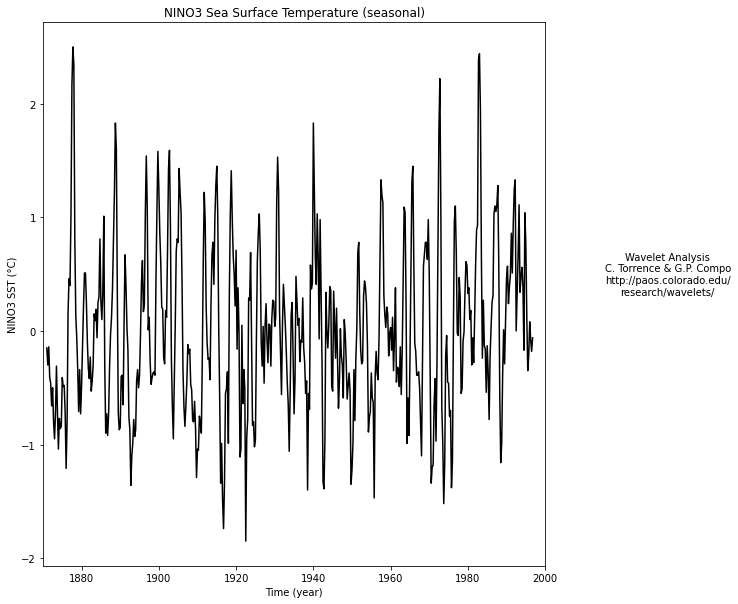

In [91]:
# --- Plot time series
plt.figure(figsize=(9, 10))
plt.plot(time, sst, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('NINO3 SST (°C)')
plt.title('NINO3 Sea Surface Temperature (seasonal)')
plt.text(time[-1] + 35, 0.5, 'Wavelet Analysis\nC. Torrence & G.P. Compo\n'
    'http://paos.colorado.edu/\nresearch/wavelets/',
    horizontalalignment='center', verticalalignment='center')
plt.show()

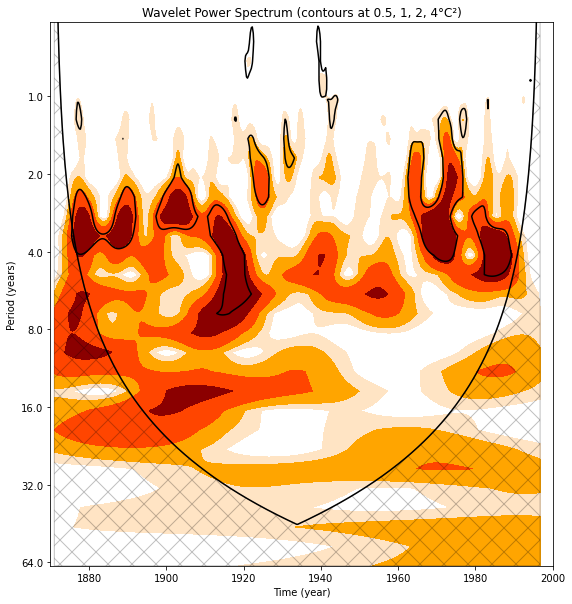

In [92]:
# --- Contour plot wavelet power spectrum
plt.figure(figsize=(9, 10))
levels = [0, 0.5, 1, 2, 4, 999]
CS = plt.contourf(time, period, power, len(levels))
im = plt.contourf(CS, levels=levels, colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
plt.xlabel('Time (year)')
plt.ylabel('Period (years)')
plt.title('Wavelet Power Spectrum (contours at 0.5, 1, 2, 4°C²)')
plt.xlim(xlim[:])
plt.contour(time, period, sig95, [-99, 1], colors='k')
plt.fill_between(time, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#00000040", hatch='x')
plt.plot(time, coi, 'k')
plt.yscale('log', base=2)
plt.ylim([np.min(period), np.max(period)])
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

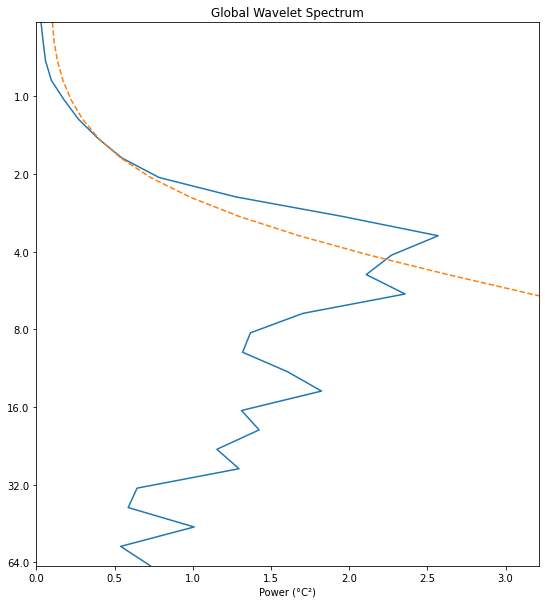

In [93]:
# --- Plot global wavelet spectrum
plt.figure(figsize=(9, 10))
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power (°C²)')
plt.title('Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
plt.yscale('log', base=2)
plt.ylim([np.min(period), np.max(period)])
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.gca().invert_yaxis()
plt.show()

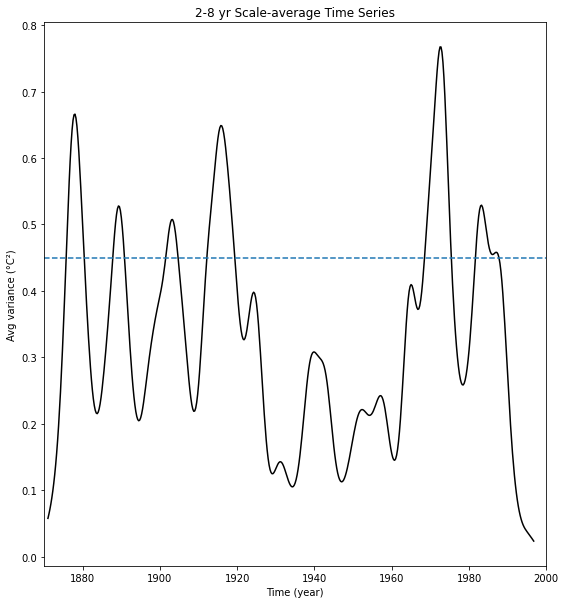

In [94]:
# --- Plot 2--8 yr scale-average time series
plt.figure(figsize=(9, 10))
plt.plot(time, scale_avg, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('Avg variance (°C²)')
plt.title('2-8 yr Scale-average Time Series')
plt.plot(xlim, scaleavg_signif + [0, 0], '--')
plt.show()